In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np

#For plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.rcParams["animation.html"] = "jshtml"
mpl.rcParams['figure.facecolor'] = 'white'
plt.rcParams["image.origin"] = "lower"


from gpuocean.SWEsimulators import CDKLM16, KP07
from gpuocean.utils import Common, IPythonMagic, PlotHelper

In [2]:
%cuda_context_handler gpu_ctx

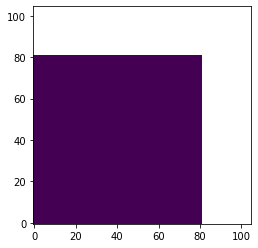

In [3]:
sim_args = {
"gpu_ctx": gpu_ctx,
"nx": 100, "ny": 100,
"dx": 200.0, "dy": 200.0,
"dt": 1,
"g": 9.81,
"f": 0.0,
"coriolis_beta": 0.0,
"r": 0.0
}

dataShape = (sim_args["ny"] + 4, 
             sim_args["nx"] + 4)

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * 60.0
H = np.ma.masked_array(H)
landmask = np.zeros_like(H)
landmask[:, 82:] = 1
landmask[82:, :] = 1
H.mask = landmask
plt.imshow(H)

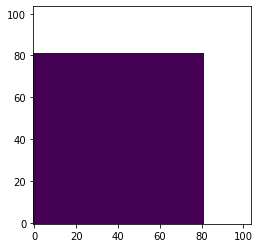

In [4]:
eta0 = np.ma.masked_array(np.ones(dataShape, dtype=np.float32), mask=H.mask[:-1,:-1])*1.0
hu0 =  np.ma.masked_array(np.zeros(dataShape, dtype=np.float32), mask=H.mask[:-1,:-1])
hv0 =  np.ma.masked_array(np.zeros(dataShape, dtype=np.float32), mask=H.mask[:-1,:-1])
plt.imshow(hu0)


In [5]:
data_args = {"H": H, "eta0": eta0, "hu0": hu0, "hv0": hv0, "rk_order": 2}
sim = CDKLM16.CDKLM16(**data_args, **sim_args)


C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:212: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


In [6]:
sim.step(100)

100.0

max(abs(  eta, hu, hv )): 1.9073486e-06 1.5513102e-05 1.5513102e-05


Text(0.5, 1.0, 'hv')

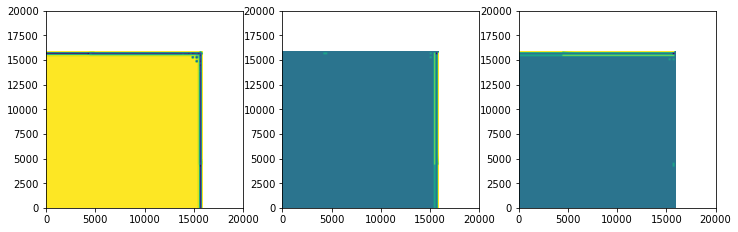

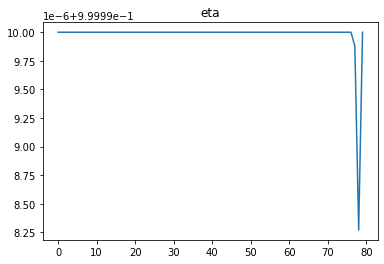

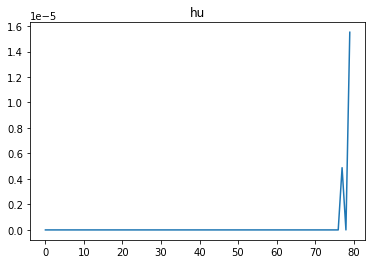

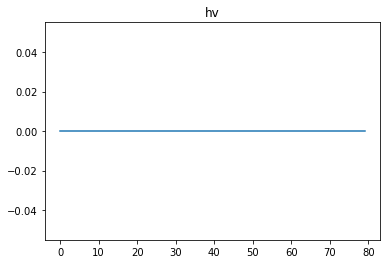

In [7]:
eta, hu, hv = sim.download(interior_domain_only=True)
fig = plt.figure(figsize=(12,8))
domain_extent = [0, sim.nx*sim.dx, 0, sim.ny*sim.dy]
ax_eta = plt.subplot(1,3,1)
ax_eta.imshow(eta, extent=domain_extent)

ax_u = plt.subplot(1,3,2)
ax_u.imshow(hu,extent=domain_extent)
    
ax_v = plt.subplot(1,3,3)
ax_v.imshow(hv, extent=domain_extent)

print("max(abs(  eta, hu, hv )):", np.max(np.abs(eta-np.max(eta0))), np.max(np.abs(hu)), np.max(np.abs(hv)))

fig = plt.figure()
plt.plot(eta[20, :])
plt.title("eta")
fig = plt.figure()
plt.plot(hu[20, :])
plt.title("hu")
fig = plt.figure()
plt.plot(hv[20, :])
plt.title("hv")


# Wave with and without landmask

(81, 81)


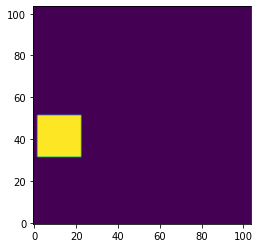

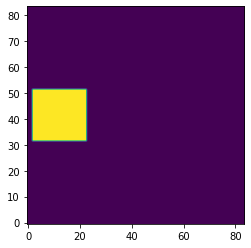

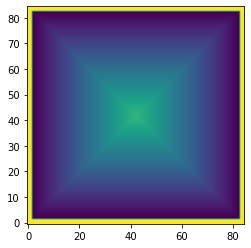

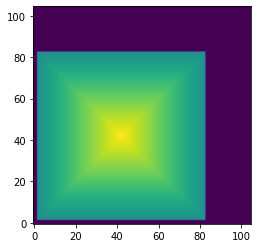

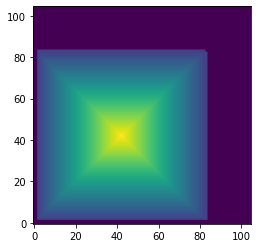

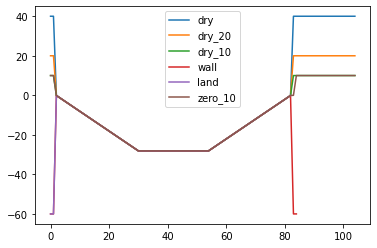

In [8]:
sim_args_wall = {
"gpu_ctx": gpu_ctx,
"nx": 80, "ny": 80,
"dx": 200.0, "dy": 200.0,
"dt": 1,
"g": 9.81,
"f": 0.0,
"coriolis_beta": 0.0,
"r": 0.0
}

dataShape_wall = (sim_args_wall["ny"] + 4, 
                  sim_args_wall["nx"] + 4)

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * 60.0
H = np.ma.masked_array(H)
landmask = np.zeros_like(H)
landmask[:, 82:] = 1
landmask[82:, :] = 1
H.mask = landmask

H_wall = np.ones((dataShape_wall[0]+1, dataShape_wall[1]+1), dtype=np.float32) * 60.0
eta0_wall = np.zeros(dataShape_wall, dtype=np.float32)
hu0_wall =  np.zeros(dataShape_wall, dtype=np.float32)
hv0_wall =  np.zeros(dataShape_wall, dtype=np.float32)

eta0_land = np.ma.masked_array(np.zeros(dataShape, dtype=np.float32)) #, mask=H.mask[1:,1:])

#eta0_wall[32:52, 32:52] = 1.0
#eta0_land[32:52, 32:52] = 1.0
#eta0_wall[32:52, 62:83] = 1.0
#eta0_land[32:52, 62:83] = 1.0
eta0_wall[32:52, 2:23] = 1.0
eta0_land[32:52, 2:23] = 1.0
#eta0_wall[:, 32:52] = 1.0
#eta0_land[:, 32:52] = 1.0 
#eta0_land += 1.0
#eta0_wall += 1.0
plt.imshow(eta0_land.data)
fig = plt.figure()
plt.imshow(eta0_wall)

new_H = np.zeros((81,81))
print(new_H.shape)
for j in range(81):
    for i in range(81):
        new_H[j, i] = 40.1 - max(np.abs(j-40), np.abs(i - 40))
        

H_dry = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * (- 40.0)
H_dry_20 = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * (- 20.0)
H_dry_10 = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * (- 10.0)
H_zero_10 = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * (- 10.0) 

for j in range(81):
    for i in range(81):
        high_land = 0.0
        #if (i > 80 or j > 80) :
        #    high_land = -20.0
        H_dry[j+2, i+2] = 40.1 - max(np.abs(j-40), np.abs(i - 40)) + high_land
        H_dry_20[j+2, i+2] = 40.1 - max(np.abs(j-40), np.abs(i - 40)) + high_land
        H_dry_10[j+2, i+2] = 40.1 - max(np.abs(j-40), np.abs(i - 40)) + high_land
        H_zero_10[j+2, i+2] = 40.1 - max(np.abs(j-40), np.abs(i - 40)) + high_land

H_zero_10[81+2, 2:81+2] = 0.0
H_zero_10[2:81+2, 81+2] = 0.0


H_wall[2:-2, 2:-2] = new_H
H[2:-22, 2:-22] = new_H

fig = plt.figure()
plt.imshow(H_wall)
fig = plt.figure()
plt.imshow(H_dry)
fig = plt.figure()
plt.imshow(H_zero_10)
fig = plt.figure()
plt.plot(-H_dry[:, 30], label="dry")
plt.plot(-H_dry_20[:, 30], label="dry_20")
plt.plot(-H_dry_10[:, 30], label="dry_10")
plt.plot(-H_wall[:, 30], label="wall")
plt.plot(-H[:, 30], label="land")
plt.plot(-H_zero_10[:, 30], label="zero_10")
plt.legend()

rk_order = 2
data_args_wall = {"H": H_wall, "eta0": eta0_wall, "hu0": hu0_wall, "hv0": hv0_wall, "rk_order": rk_order}
data_args_land = {"H": H,      "eta0": eta0_land, "hu0": hu0, "hv0": hv0, "rk_order": rk_order}
data_args_dry = {"H": H_dry,  "eta0": eta0_land, "hu0": hu0.data, "hv0": hv0.data, "rk_order": rk_order}
data_args_dry_20 = {"H": H_dry_20,  "eta0": eta0_land, "hu0": hu0.data, "hv0": hv0.data, "rk_order": rk_order}
data_args_dry_10 = {"H": H_dry_10,  "eta0": eta0_land, "hu0": hu0.data, "hv0": hv0.data, "rk_order": rk_order}
data_args_zero_10 = {"H": H_zero_10,  "eta0": eta0_land, "hu0": hu0.data, "hv0": hv0.data, "rk_order": rk_order}


In [9]:
sim_args_wall["f"] = 0.0012
sim_args["f"] = 0.0012

sim_wall = CDKLM16.CDKLM16(**data_args_wall, **sim_args_wall)
sim_land = CDKLM16.CDKLM16(**data_args_land, **sim_args)
sim_dry = CDKLM16.CDKLM16(**data_args_dry, **sim_args)
sim_dry_20 = CDKLM16.CDKLM16(**data_args_dry_20, **sim_args)
sim_dry_10 = CDKLM16.CDKLM16(**data_args_dry_10, **sim_args)
sim_zero_10 = CDKLM16.CDKLM16(**data_args_zero_10, **sim_args)

#T = 200
#
#T = 470*5*5
T = sim_wall.dt*3500*4
sim_wall.step(T)
sim_land.step(T)
sim_dry.step(T)
sim_dry_20.step(T)
sim_dry_10.step(T)
sim_zero_10.step(T)


eta_land,   hu_land,    hv_land    = sim_land.download(interior_domain_only=True)
eta_wall,   hu_wall,    hv_wall    = sim_wall.download(interior_domain_only=True)
eta_dry,    hu_dry,     hv_dry     =  sim_dry.download(interior_domain_only=True)
eta_dry_20, hu_dry_20,  hv_dry_20  =  sim_dry_20.download(interior_domain_only=True)
eta_dry_10, hu_dry_10,  hv_dry_10  =  sim_dry_10.download(interior_domain_only=True)
eta_zero_10, hu_zero_10,  hv_zero_10  =  sim_zero_10.download(interior_domain_only=True)


print("coriolis (wall, land):", (sim_wall.f, sim_land.f))

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:212: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


coriolis (wall, land): (0.0012, 0.0012)


fig = plt.figure(figsize=(7,7))
ax_eta = plt.subplot(1,3,1)
ax_eta.imshow(eta_land[20:60,75:85])
ax_u = plt.subplot(1,3,2)
ax_u.imshow(hu_land[20:60, 75:85])
ax_v = plt.subplot(1,3,3)
sp_v = ax_v.imshow(hv_land[20:60, 75:85])

fig = plt.figure(figsize=(7,7))
ax_eta = plt.subplot(1,3,1)
ax_eta.imshow(eta_wall[20:60,75:85])
ax_u = plt.subplot(1,3,2)
ax_u.imshow(hu_wall[20:60, 75:85])
ax_v = plt.subplot(1,3,3)
sp_v = ax_v.imshow(hv_wall[20:60, 75:85])



420.0 420.19495 413.3683 416.80475 415.85385 414.8651 404.3935
init, wall,     land,     dry 40,  dry 20,   dry 10,   zero 10
<class 'numpy.ndarray'>


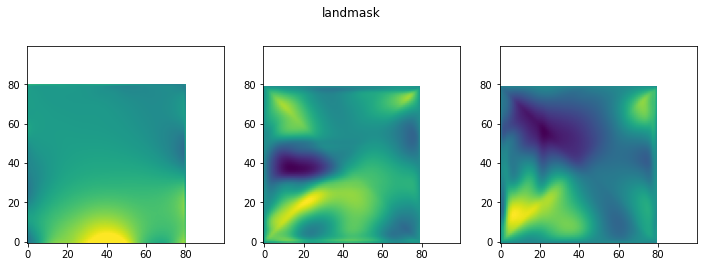

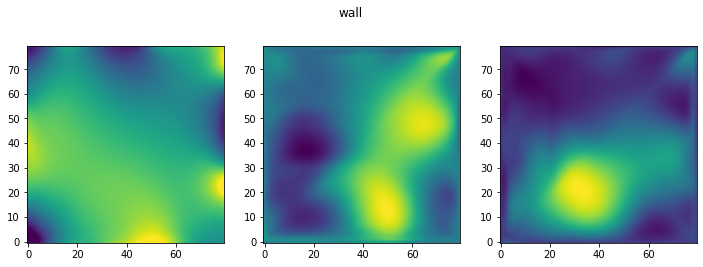

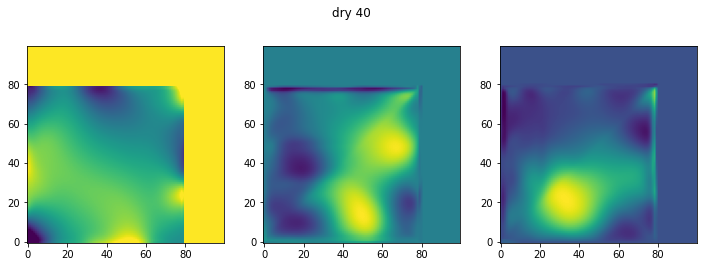

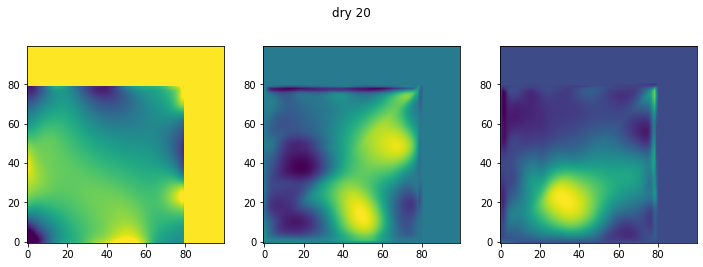

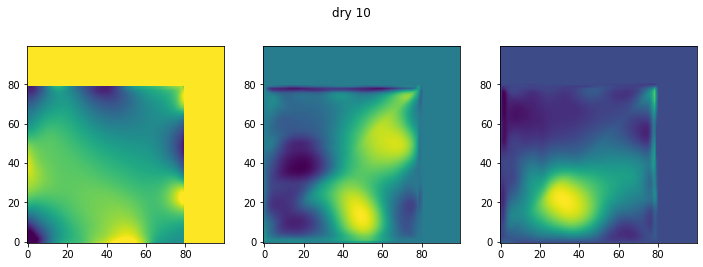

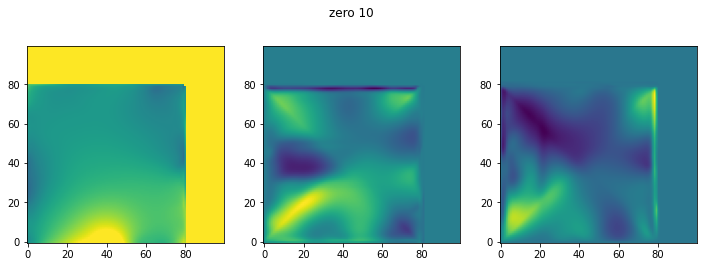

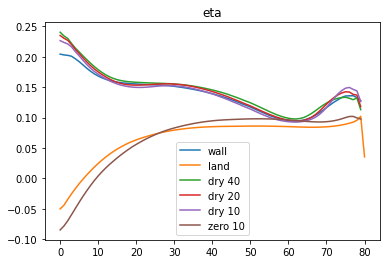

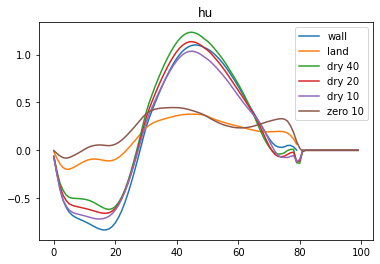

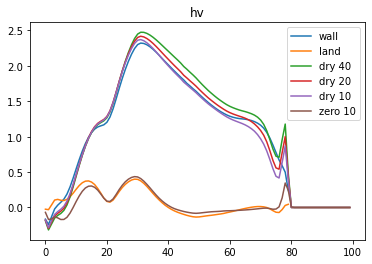

In [10]:
def plotstate(eta, hu, hv, title):
    fig = plt.figure(figsize=(12,4))
    ax_eta = plt.subplot(1,3,1)
    ax_eta.imshow(eta, vmin=-0.3, vmax=0.3)
    ax_u = plt.subplot(1,3,2)
    ax_u.imshow(hu)
    ax_v = plt.subplot(1,3,3)
    sp_v = ax_v.imshow(hv)
    #plt.colorbar(sp_v, ax= ax_v, shrink=0.5)
    plt.suptitle(title)

plotstate(eta_land, hu_land, hv_land, "landmask")
plotstate(eta_wall, hu_wall, hv_wall, "wall")
plotstate(eta_dry, hu_dry, hv_dry, "dry 40")
plotstate(eta_dry_20, hu_dry_20, hv_dry_20, "dry 20")
plotstate(eta_dry_10, hu_dry_10, hv_dry_10, "dry 10")
plotstate(eta_zero_10, hu_zero_10, hv_zero_10, "zero 10")

fig = plt.figure()
plt.plot(eta_wall[30, :], label="wall")
plt.plot(eta_land[30, :], label="land")
plt.plot(eta_dry[30, :80], label="dry 40")
plt.plot(eta_dry_20[30, :80], label="dry 20")
plt.plot(eta_dry_10[30, :80], label="dry 10")
plt.plot(eta_zero_10[30, :80], label="zero 10")
#plt.plot(np.maximum(eta_dry[30, :], -(0.5*(H_dry[30,3:-2] + H_dry[30,2:-3]))), label="dry")
plt.legend()
plt.title("eta")

fig = plt.figure()
plt.plot(hu_wall[30, :], label="wall")
plt.plot(hu_land[30, :], label="land")
plt.plot(hu_dry[30, :], label="dry 40")
plt.plot(hu_dry_20[30, :], label="dry 20")
plt.plot(hu_dry_10[30, :], label="dry 10")
plt.plot(hu_zero_10[30, :], label="zero 10")
plt.legend()
plt.title("hu")

fig = plt.figure()
plt.plot(hv_wall[30, :], label="wall")
plt.plot(hv_land[30, :], label="land")
plt.plot(hv_dry[30, :], label="dry 40")
plt.plot(hv_dry_20[30, :], label="dry 20")
plt.plot(hv_dry_10[30, :], label="dry 10")
plt.plot(hv_zero_10[30, :], label="zero 10")
#plt.plot([30, 30], [-1,1])
#plt.plot([50, 50], [-1,1])
plt.legend()
plt.title("hv")

print(np.sum(eta0_wall[2:-2, 2:-2]), np.sum(eta_wall[:80, :80]), np.sum(eta_land[:80, :80]), np.sum(eta_dry[:80, :80]), np.sum(eta_dry_20[:80, :80]), np.sum(eta_dry_10[:80, :80]), np.sum(eta_zero_10[:80, :80]))
print("init, wall,     land,     dry 40,  dry 20,   dry 10,   zero 10")

print(type(hu_dry))

# 400.0 400.00415 393.75104 <-- without the PR
# 400.0 400.00415 395.49026 <-- original PR
# 400.0 400.00415 395.48944 <-- with -vp
# 400.0 400.00415 395.488   <-- with 5*(-vp)


In [11]:
(0.5*(H_dry[30,1:] + H_dry[30,:-1])).shape

(104,)

In [12]:
eta_land.shape

(100, 100)

Text(0.5, 1.0, 'hu land')

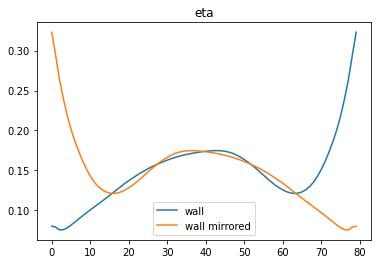

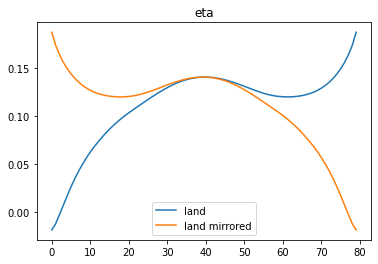

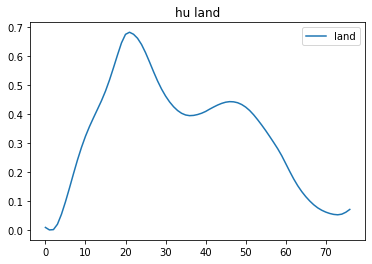

In [13]:
fig = plt.figure()
plt.plot(eta_wall[20, :], label="wall")
plt.plot(np.arange(79, -1, -1), eta_wall[20, :], label="wall mirrored")
plt.legend()
plt.title("eta")

fig = plt.figure()
plt.plot(eta_land[20, :80], label="land")
plt.plot(np.arange(79, -1, -1), eta_land[20, :80], label="land mirrored")
plt.legend()
plt.title("eta")

fig = plt.figure()
plt.plot(hu_land[20, :77], label="land")
#plt.plot(np.arange(79, -1, -1), eta_land[20, :80], label="land mirrored")
plt.legend()
plt.title("hu land")



1e+20

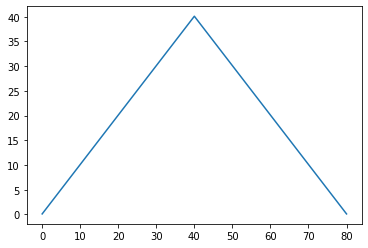

In [14]:

new_H = np.zeros((81,81))
#for j in range(81):
for i in range(81):
    new_H[:, i] = 40.1 - np.abs(i - 40)

plt.plot(new_H[23, :])

eta0_land.get_fill_value()

3.3782153 36.455727


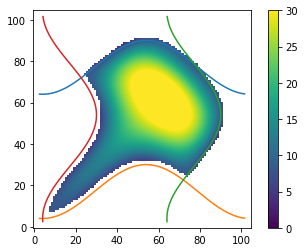

In [15]:
def getMaskedBathymetry():

    H_tri_mask = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * 60.0
    landmask_tri = np.zeros_like(H_tri_mask)

    x = np.arange(2, 102) + 0.5
    y = np.arange(2, 102) + 0.5
    
    amp = 13
    shift = 30
    def x1(x): 
        return 120 - shift - amp *(1 + np.cos(2*np.pi*(x-2)/(100)))
    def x2(x):
        return shift - amp*(1 + np.cos(2*np.pi*(x-2)/(100)))
    def y1(y):
        return 120 - shift - amp*(1 + np.cos(2*np.pi*(y-2)/(100)))
    def y2(y):
        return shift - amp*(1 + np.cos(2*np.pi*(y-2)/(100)))

    plt.plot(x, x1(x-2))
    plt.plot(x, x2(x-2))
    plt.plot(y1(y-2), x)
    plt.plot(y2(y-2), x)
    for y in range(-2, 103):
        for x in range(-2, 103):
            if ((y > y1(x)) or 
                (y < y2(x)) or
                (x > x1(y)) or
                (x < x2(y))):
                landmask_tri[y+2,x+2] = 1
            else:
                landmask_tri[y+2,x+2] = 0
            #H_tri_mask[y+2, x+2] = (y+1.5-y1(x-1.5))*(y-1.5-y2(x+1.5))#*(x+1.5-x1(y-1.5))*(x-1.5-x2(y-1.5))/(10000)
            #H_tri_mask[y+2, x+2] = (y+1.5-y1(x-1.5))*(y-1.5-y2(x+1.5))#*(x+1.5-x1(y-1.5))*(x-1.5-x2(y-1.5))/(10000)
            H_tri_mask[y+2, x+2] = (((y+1.5-y1(x-1.5))*(x+1.5-x1(y-1.5)) * (y-1.5-y2(x+1.5))*(x-1.5-x2(y+1.5))/100000) + 2)*4
            #H_tri_mask[y+2, x+2] = (y+1.5-y1(x-1.5))*(x+1.5-x1(y-1.5)) - 
        
    H_tri_mask = np.ma.masked_array(H_tri_mask)

    H_tri_mask.mask = landmask_tri
    print(np.min(H_tri_mask), np.max(H_tri_mask))

    plt.imshow(H_tri_mask, origin="lower", vmin = 0, vmax=30)
    plt.colorbar()
    return H_tri_mask

H_complex_masked = getMaskedBathymetry()

3.3782153 36.455727


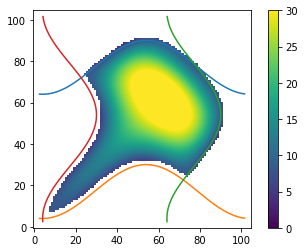

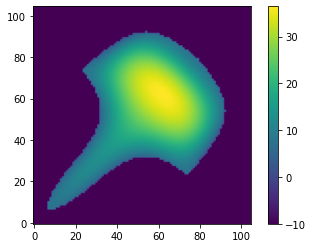

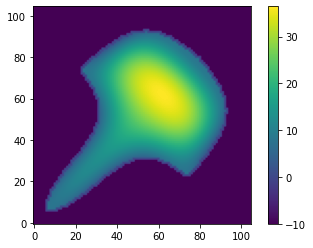

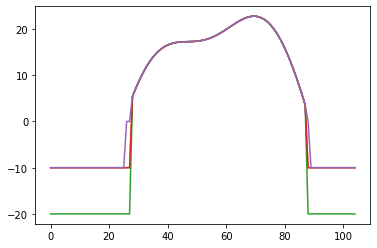

In [16]:
def dryStatesFromMasked(H_masked, landvalue):
    H_dry = np.zeros_like(H_masked.data)
    H_dry[:,:] = H_masked.data

    H_dry[H_masked.mask] = -landvalue
    #plt.imshow(H_dry, origin="lower")

    return H_dry

def dryStatesGentlyFromMaskes(H_masked, landvalue):
    H_dry = np.zeros_like(H_masked.data)
    H_dry[:,:] = H_masked.data

    H_dry[0 ,:] = -landvalue
    H_dry[-1,:] = -landvalue
    H_dry[:, 0] = -landvalue
    H_dry[:,-1] = -landvalue    
    #H_dry[H_masked.mask] = -landvalue
    
    (Nx, Ny) = H_masked.shape
    for y in range(1, Ny-1):
        for x in range(1, Nx-1):
            if H_masked.mask[y,x]:
                # This is land
                num_dry_neighbours = int(H_masked.mask[y-1,x-1]) + int(H_masked.mask[y-1,x]) + int(H_masked.mask[y-1,x+1]) + \
                                     int(H_masked.mask[y  ,x-1]) +                             int(H_masked.mask[y  ,x+1]) + \
                                     int(H_masked.mask[y+1,x-1]) + int(H_masked.mask[y+1,x]) + int(H_masked.mask[y+1,x+1])  
                if num_dry_neighbours == 8:
                    H_dry[y, x] = -landvalue
                else:
                    H_dry[y, x] = 0.0

    #plt.imshow(H_dry, origin="lower")
    #plt.colorbar()
    return H_dry


def testDryStates():
    H_complex_masked = getMaskedBathymetry()
    H_dry_40 = dryStatesFromMasked(H_complex_masked, 40)
    H_dry_20 = dryStatesFromMasked(H_complex_masked, 20)
    H_dry_10 = dryStatesFromMasked(H_complex_masked, 10)

    H_zero_10 = dryStatesGentlyFromMaskes(H_complex_masked, 10)


    plt.figure()
    plt.imshow(H_dry_10, origin="lower")
    plt.colorbar()

    plt.figure()
    plt.imshow(H_zero_10, origin="lower")
    plt.colorbar()

    plt.figure()
    y = 40
    plt.plot(H_complex_masked[:, y])
    plt.plot(H_dry_10[:, y])
    plt.plot(H_dry_20[:, y])
    plt.plot(H_dry_10[:, y])
    plt.plot(H_zero_10[:, y])


    
testDryStates()

In [17]:
def plotstate2(eta, hu, hv, title):
    fig = plt.figure(figsize=(14,4))
    ax_eta = plt.subplot(1,3,1)
    sp_eta = ax_eta.imshow(eta, vmin=-0.3, vmax=0.3)
    plt.colorbar(sp_eta, ax= ax_eta, shrink=0.5)
    
    ax_u = plt.subplot(1,3,2)
    sp_u = ax_u.imshow(hu, vmin=-5, vmax=5)
    plt.colorbar(sp_u, ax= ax_u, shrink=0.5)
    
    ax_v = plt.subplot(1,3,3)
    sp_v = ax_v.imshow(hv, vmin=-5, vmax=5)
    plt.colorbar(sp_v, ax= ax_v, shrink=0.5)
    #plt.suptitle(title)

def makeSimAndRun(H, T, plotTitle, kp=False, runCase=1):
    dataShape = np.array(H.shape) - 1

    sim_args = {
        "gpu_ctx": gpu_ctx,
        "nx": dataShape[1]-4, "ny": dataShape[0]-4,
        "dx": 200.0, "dy": 200.0,
        "dt": 1.0,
        "g": 9.81,
        "f": 0.01,
        "coriolis_beta": 0.0,
        "r": 0.0
        }
    
    eta0 = np.zeros(dataShape, dtype=np.float32)
    hu0 =  np.zeros(dataShape, dtype=np.float32)
    hv0 =  np.zeros(dataShape, dtype=np.float32)
    if runCase == 1:
        eta0[42:62, 42:62] = 1.0
    elif runCase == 2:
        for y in range(sim_args["ny"]+4):
            for x in range(sim_args["nx"]+4):
                if not ((H[y,x] < 0) and (H[y+1,x] < 0) and (H[y,x+1] < 0) and (H[y+1,x+1] < 0)):
                    eta0[y, x] = np.cos(np.pi*(x-2)/sim_args["nx"])

    data_args = {"H": H, "eta0": eta0, "hu0": hu0, "hv0": hv0}

    sim = None
    if kp:
        sim = KP07.KP07(**data_args, **sim_args)
    else:
        sim = CDKLM16.CDKLM16(**data_args, **sim_args)
    
    sim.step(T)

    eta, hu, hv = sim.download(interior_domain_only=True)
    print(plotTitle, sim.t)
    plotstate2(eta, hu, hv, plotTitle)

    return eta, hu, hv


landmask 3000.0
dry10 CDKLM 3000.0
zero10 CDKLM 3000.0
zero20 CDKLM 3000.0


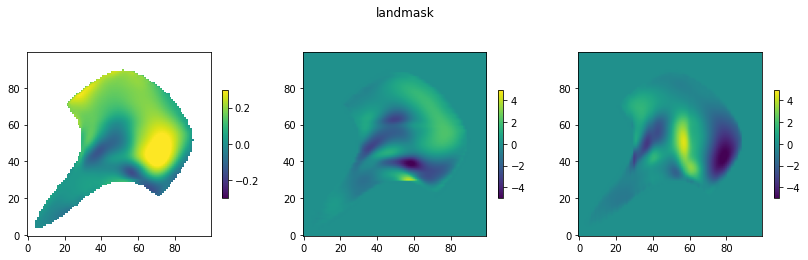

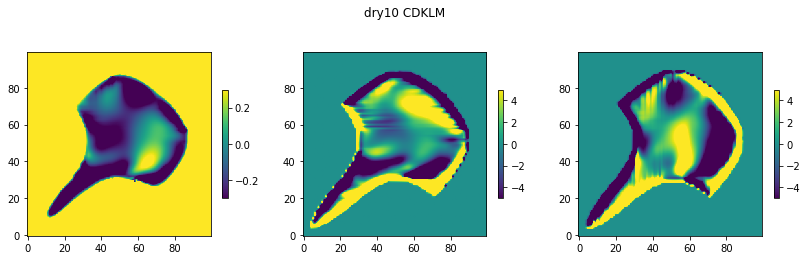

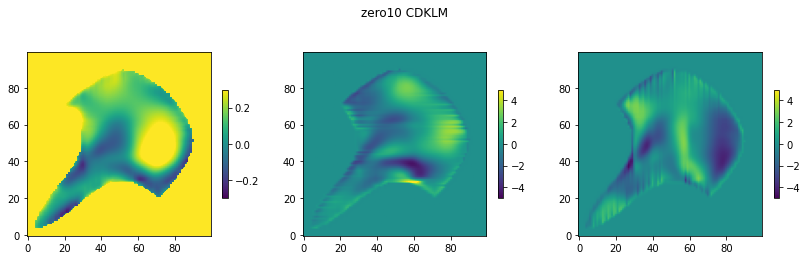

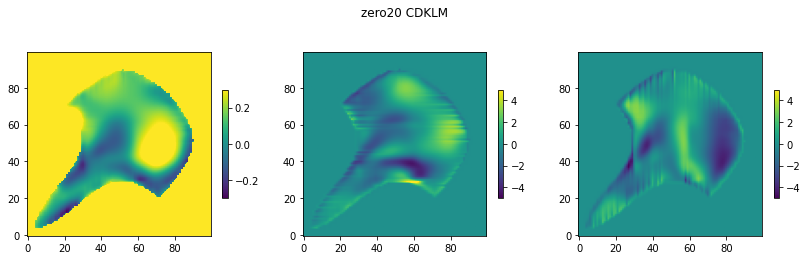

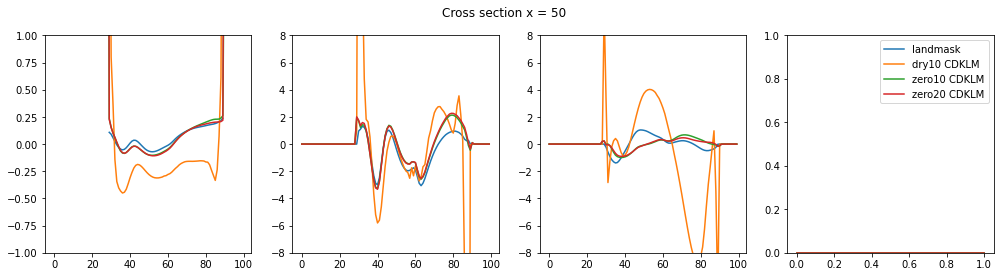

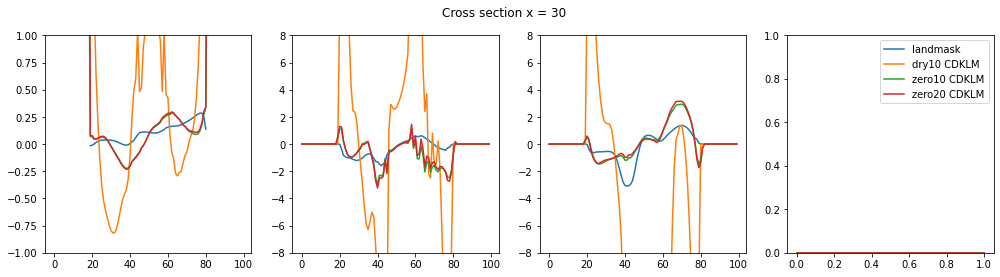

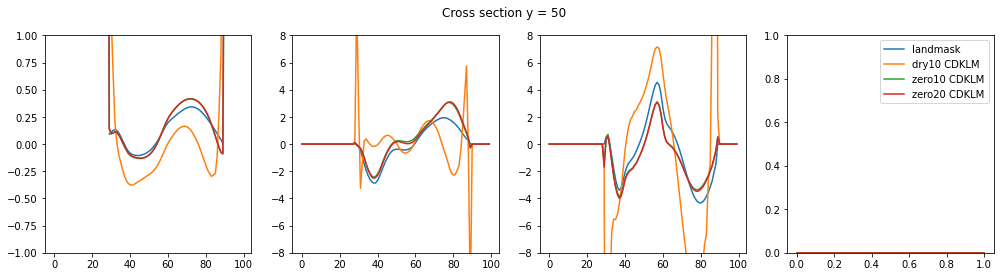

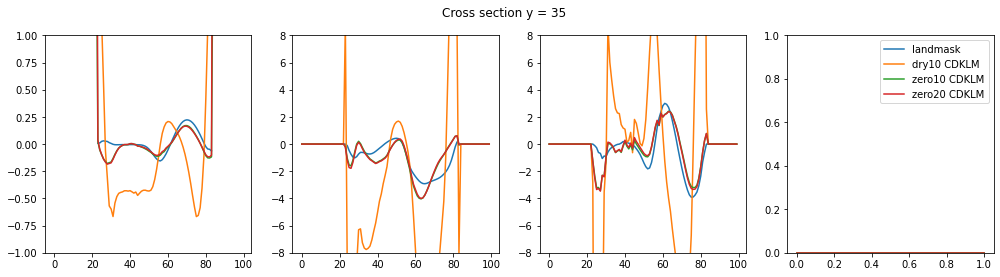

In [18]:
from importlib import reload

reload(CDKLM16)
reload(KP07)

def runAllAndCrossSections():
    T = 3000

    runCase = 1

    data = [
        ["landmask", False, H_complex_masked ],
        #["dry40 CDKLM",    False, dryStatesFromMasked(H_complex_masked, 40) ],
        #["dry20 CDKLM",    False, dryStatesFromMasked(H_complex_masked, 20) ],
        ["dry10 CDKLM",    False, dryStatesFromMasked(H_complex_masked, 10) ],
        #["dry40 KP", True,  dryStatesFromMasked(H_complex_masked, 40) ],
        #["dry20 KP", True,  dryStatesFromMasked(H_complex_masked, 20) ],
        #["dry10 KP", True,  dryStatesFromMasked(H_complex_masked, 10) ],
        ["zero10 CDKLM", False, dryStatesGentlyFromMaskes(H_complex_masked, 10) ],
        ["zero20 CDKLM", False, dryStatesGentlyFromMaskes(H_complex_masked, 20) ],
        
    ]

    N = len(data)

    labels = [None]*N
    Hs     = [None]*N
    kp     = [None]*N
    states = [None]*N

    for i in range(N):
        labels[i] = data[i][0]
        kp[i]     = data[i][1]
        Hs[i]     = data[i][2]

    for i in range(N):
        states[i] = makeSimAndRun(Hs[i], T, labels[i], kp=kp[i], runCase=runCase)
        plt.suptitle(labels[i])
        
    
    def plotCrossSectionX(x):

        fig = plt.figure(figsize=(17,4))
        
        ax_eta = plt.subplot(1,4,1)
        for i in range(N):
            ax_eta.plot(states[i][0][:,x], label=labels[i])
        ax_eta.set_ylim([-1, 1])
        #ax_eta.legend()

        ax_hu = plt.subplot(1,4,2)
        for i in range(N):
            ax_hu.plot(states[i][1][:,x], label=labels[i])
        ax_hu.set_ylim([-8, 8])
        #ax_hu.legend()

        ax_hv = plt.subplot(1,4,3)
        for i in range(N):
            ax_hv.plot(states[i][2][:,x], label=labels[i])
        ax_hv.set_ylim([-8, 8])
        
        ax_legend = plt.subplot(1,4,4)
        for i in range(N):
            ax_legend.plot([0, 1], [0, 0], label=labels[i])
        ax_legend.set_ylim([0, 1])
        ax_legend.legend()
        plt.suptitle("Cross section x = " + str(x))
        
    plotCrossSectionX(50)
    plotCrossSectionX(30)

    def plotCrossSectionY(y):

        fig = plt.figure(figsize=(17,4))
        
        ax_eta = plt.subplot(1,4,1)
        for i in range(N):
            ax_eta.plot(states[i][0][y,:], label=labels[i])
        ax_eta.set_ylim([-1, 1])
        #ax_eta.legend()

        ax_hu = plt.subplot(1,4,2)
        for i in range(N):
            ax_hu.plot(states[i][1][y,:], label=labels[i])
        ax_hu.set_ylim([-8, 8])
        #ax_hu.legend()

        ax_hv = plt.subplot(1,4,3)
        for i in range(N):
            ax_hv.plot(states[i][2][y,:], label=labels[i])
        ax_hv.set_ylim([-8, 8])
        
        ax_legend = plt.subplot(1,4,4)
        for i in range(N):
            ax_legend.plot([0, 1], [0, 0], label=labels[i]) 
        ax_legend.set_ylim([0, 1])
        ax_legend.legend()
        plt.suptitle("Cross section y = " + str(y))
        
    plotCrossSectionY(50)
    plotCrossSectionY(35)

runAllAndCrossSections()

### Lesson learned

* After the bug fix, KP and CDKLM behavews very similarly (although, not identically)
* CDKLM with the zero at land mask border behaves similar with landvalues 10 and 20
* Zero bathymetry at the wet-dry interface results in no initial waves (Although, I guess tides will still struggle a bit)
* Zero at wet-dry gives much smoother values in hu and hv
* When starting with some tide, the zero at wet-dry solution is very similar that of land mask. The cliff option is chaotic
* With rotation (f = 0.01) and tide,  we get a sharper momentum along land with the zero option compared to the landmask. 
* With rotation (f = 0.01) and square init, landmask and zero option gives very similar results

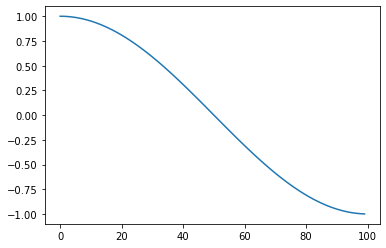

In [19]:
plt.plot(np.cos(np.pi*np.arange(0,100)/100))

## Test intersection bathymetry to zero at the landmask interface on realistic domains!!!
